# Exploration of latent variable space

## Take some examples sentence, craft 20 perturbations of them using 3 different methods

In [ ]:
from textattack.augmentation import CharSwapAugmenter, WordNetAugmenter, EasyDataAugmenter

In [ ]:
# from textattack.augmentation import EmbeddingAugmenter

In [ ]:
# Define some sentences to be used as starting points
simple_sentence = "i like movies"
medium_sentence = "watching the jaws was a quite terrifying experience"
difficult_sentence = "john had to write to the right people to keep his rights during his rites"
orig_sentences = {
                    "simple": simple_sentence,
                    "medium": medium_sentence,
                    "difficult": difficult_sentence
                 }

In [ ]:
# perturbed = defaultdict(lambda x: defaultdict(list))
perturbed = {}

In [ ]:
def perturb_sentences(augmenter, sentences):
    results = {}
    for key in sentences.keys():
        base_sentence = sentences[key]
        results[key] = augmenter.augment(base_sentence)
    return results

In [ ]:
k = 20

In [ ]:
augmenter = CharSwapAugmenter(transformations_per_example=k)
perturbed["CharSwap"] = perturb_sentences(augmenter, orig_sentences)

In [ ]:
# Fat
# augmenter = CheckListAugmenter()
# perturbed["CheckList"] = perturb_sentences(augmenter, orig_sentences)

In [ ]:
# Takes long to load
# augmenter = EmbeddingAugmenter()
# perturbed["EmbeddingAugment"] = perturb_sentences(augmenter, orig_sentences)

In [ ]:
# This is good
augmenter = WordNetAugmenter(transformations_per_example=k)
perturbed["WordNetSynonyms"] = perturb_sentences(augmenter, orig_sentences)

In [ ]:
# Might change the meaning of a sentence quite a bit
augmenter = EasyDataAugmenter(transformations_per_example=k)
perturbed["EasyData"] = perturb_sentences(augmenter, orig_sentences)

In [ ]:
# Write the perturbed sentences to file
import csv
with open("perturbed_sentences.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(("perturb_method", "difficulty", "sentence"))
    writer.writerow(("none", "simple", simple_sentence))
    writer.writerow(("none", "medium", medium_sentence))
    writer.writerow(("none", "difficult", difficult_sentence))
    for method in perturbed.keys():
        for difficulty in perturbed[method].keys():
            for sentence in perturbed[method][difficulty]:
                writer.writerow((method, difficulty, sentence))

## Comparing sentence representations using different word embeddings 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from collections import defaultdict

from gensim import utils
from gensim.models import TfidfModel, Word2Vec, FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.corpora import Dictionary
from gensim.utils import tokenize
from gensim.test.utils import datapath

from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

In [ ]:
class DataIter:
    def __init__(self, path):
        self.path = datapath(path)
    
    def __iter__(self):
        with utils.open(self.path, 'r', encoding='utf-8') as fin:
            for line in fin:
                yield list(tokenize(line))

In [ ]:
imdb_path = "/home/paulius/Personal/Personal/Pauliaus/Lectures/Maastricht/Year 3/Thesis/sent-verification/external-repos/txt-autoencoders/data/imdb/train_imdb_without_sentiment.txt"
imdb_iter = DataIter(imdb_path)

###  Training different word vectors

### TF-IDF

In [ ]:
print("Building dictionary...")
dct = Dictionary(imdb_iter)
print("Building model...")
corpus = [dct.doc2bow(line) for line in imdb_iter]
tfidf_model = TfidfModel(corpus)
print("Saving model...")
tfidf_model.save("imdb_tfidf.model")

### Word2Vec

In [ ]:
word2vec_model = Word2Vec(size=100, window=5)
print("Building vocab...")
word2vec_model.build_vocab(sentences=imdb_iter)
total_examples = word2vec_model.corpus_count
print("Training model...")
word2vec_model.train(sentences=imdb_iter, total_examples=total_examples, epochs=30)
print("Saving model...")
word2vec_model.save("imdb_word2vec.model")

### Pre-trained GloVe (twitter, wiki)

In [ ]:
# import gensim.downloader
# glove_twitter_100_vectors = gensim.downloader.load("glove-twitter-100")
# glove_wiki_100_vectors = gensim.downloader.load("glove-wiki-gigaword-100")

### FastText

In [ ]:
fasttext_model = FastText(size=100, window=5)
print("Building vocab...")
fasttext_model.build_vocab(sentences=imdb_iter)
total_examples = fasttext_model.corpus_count
print("Training model...")
fasttext_model.train(sentences=imdb_iter, total_examples=total_examples, epochs=30)
print("Saving model...")
fasttext_model.save("imdb_fasttext.model")

### Doc2Vec

In [ ]:
print("Building documents...")
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(imdb_iter)]
print("Training model...")
doc2vec_model = Doc2Vec(documents, vector_size=100, window=5)
print("Saving model...")
doc2vec_model.save("imdb_doc2vec.model")

### Visualize words

In [ ]:
def reduce_dimensions(model, num_words=100):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later

    i = 0
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
        if i == num_words:
            break
        i += 1

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')


def plot_with_matplotlib(x_vals, y_vals, labels, num_words=25):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled num_words data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, num_words)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

In [ ]:
# Define the number of words to visualize
num_words_viz = 10000

In [ ]:
tfidf_model = TfidfModel.load("imdb_tfidf.model")
print("Building dictionary...")
tfidf_dct = Dictionary(imdb_iter)
print("Building corpus...")
corpus = [dct.doc2bow(line) for line in imdb_iter]

In [ ]:
viz_corpus = corpus[:num_words_viz]
vectors = []
for word in viz_corpus:
    tmp_vec = []
    for _, value in tfidf_model[word]:
        tmp_vec.append(value)
    vectors.append(tmp_vec)
x_vals, y_vals, labels = reduce_dimensions_sentence(vectors, viz_corpus)
plot_with_matplotlib(x_vals, y_vals, labels, 100)

In [ ]:
word2vec_model = Word2Vec.load("imdb_word2vec.model")
x_vals, y_vals, labels = reduce_dimensions(word2vec_model, num_words_viz)
plot_with_matplotlib(x_vals, y_vals, labels, 100)

In [ ]:
fasttext_model = FastText.load("imdb_fasttext.model")
x_vals, y_vals, labels = reduce_dimensions(fasttext_model, num_words_viz)
plot_with_matplotlib(x_vals, y_vals, labels, 100)

In [ ]:
doc2vec_model = Doc2Vec.load("imdb_doc2vec.model")
x_vals, y_vals, labels = reduce_dimensions(doc2vec_model, num_words_viz)
plot_with_matplotlib(x_vals, y_vals, labels, 100)

### Compute sentence representations by  averaging out  word vectors

In [ ]:
def avg_word_vectors(model, sentence):    
    vectors = []
    # Split sentence into word tokens
    words = list(tokenize(sentence))
    # For each word in the sentece...
    for word in words:
        # Get its vector using the model
        try:
            vectors.append(model.wv[word])
        except KeyError:
            # If we encounter an out-of-vocabulary word, skip it
            pass
        
    # Compute mean element-wise
    return np.mean(vectors, axis=0)

def add_sentence_to_dict(dictionary, model, sentence, perturb, difficulty):
    avg_vector = avg_word_vectors(model, sentence)
    dictionary["sentence"].append(sentence)
    dictionary["vector"].append(avg_vector)
    dictionary["perturb_method"].append(perturb)
    dictionary["difficulty"].append(difficulty)
    dictionary["model"].append(type(model).__name__)
    
def add_sentence_to_dict_doc2vec(dictionary, model, sentence, perturb, difficulty):
    vector = model.infer_vector(list(tokenize(sentence)))
    dictionary["sentence"].append(sentence)
    dictionary["vector"].append(vector)
    dictionary["perturb_method"].append(perturb)
    dictionary["difficulty"].append(difficulty)
    dictionary["model"].append(type(model).__name__)
    
def add_sentence_to_dict_tfidf(dictionary, model, dct, sentence, perturb, difficulty):
    vector = model[dct.doc2bow(list(tokenize(sentence)))]
    dictionary["sentence"].append(sentence)
    dictionary["vector"].append(vector)
    dictionary["perturb_method"].append(perturb)
    dictionary["difficulty"].append(difficulty)
    dictionary["model"].append(type(model).__name__)

In [ ]:
transformed = defaultdict(list)

In [ ]:
tfidf_model = TfidfModel.load("imdb_tfidf.model")
word2vec_model = Word2Vec.load("imdb_word2vec.model")
fasttext_model = FastText.load("imdb_fasttext.model")
doc2vec_model = Doc2Vec.load("imdb_doc2vec.model")

In [ ]:
perturbed = pd.read_csv("perturbed_sentences.csv")
perturb_methods = list(pd.unique(perturbed["perturb_method"]))
perturb_methods.remove("none")
difficulties = list(pd.unique(perturbed["difficulty"]))
models = ["Word2Vec", "FastText", "Doc2Vec"]

In [ ]:
# TF-IDF
# Should the tfidf_dct be passed here or some other?
for perturb_method in perturb_methods:
    for difficulty in difficulties:
        if difficulty == "simple":
            add_sentence_to_dict_tfidf(transformed, tfidf_model, simple_sentence, "none", difficulty)
        elif difficulty == "medium":
            add_sentence_to_dict_tfidf(transformed, tfidf_model, medium_sentence, "none", difficulty)
        elif difficulty == "difficult":
            add_sentence_to_dict_tfidf(transformed, tfidf_model, difficult_sentence, "none", difficulty)
        for sentence in perturbed[perturb_method][difficulty]:
            add_sentence_to_dict_tfidf(transformed, tfidf_model, tfidf_dct, sentence, perturb_method, difficulty)

In [ ]:
# Classic word embeddings models
for model in [word2vec_model, fasttext_model]:
    for perturb_method in perturb_methods:
        for difficulty in difficulties:
            if difficulty == "simple":
                add_sentence_to_dict(transformed, model, simple_sentence, "none", difficulty)
            elif difficulty == "medium":
                add_sentence_to_dict(transformed, model, medium_sentence, "none", difficulty)
            elif difficulty == "difficult":
                add_sentence_to_dict(transformed, model, difficult_sentence, "none", difficulty)

            filtered = perturbed[perturbed["perturb_method"] == perturb_method]
            filtered = filtered[filtered["difficulty"] == difficulty]
            for sentence in filtered["sentence"]:
                add_sentence_to_dict(transformed, model, sentence, perturb_method, difficulty)

In [ ]:
# Doc2Vec
for perturb_method in perturb_methods:
    for difficulty in difficulties:
        if difficulty == "simple":
            add_sentence_to_dict_doc2vec(transformed, doc2vec_model, simple_sentence, "none", difficulty)
        elif difficulty == "medium":
            add_sentence_to_dict_doc2vec(transformed, doc2vec_model, medium_sentence, "none", difficulty)
        elif difficulty == "difficult":
            add_sentence_to_dict_doc2vec(transformed, doc2vec_model, difficult_sentence, "none", difficulty)
            
        filtered = perturbed[perturbed["perturb_method"] == perturb_method]
        filtered = filtered[filtered["difficulty"] == difficulty]
        for sentence in filtered["sentence"]:
            add_sentence_to_dict_doc2vec(transformed, doc2vec_model, sentence, perturb_method, difficulty)

In [ ]:
sentence_df = pd.DataFrame(transformed, columns=["sentence", "vector", "perturb_method", "difficulty", "model"])
sentence_df.to_csv("transformed_sentences.csv")
sentence_df.head()

In [ ]:
x_vals, y_vals, labels = reduce_dimensions_sentence(filtered["vector"], filtered["sentence"])
plot_with_matplotlib(x_vals, y_vals, labels, 100)

In [ ]:
from scipy.spatial import distance

cosine_distances = []
euclidean_distances = []
for model in models:
    filtered_model = sentence_df[sentence_df["model"] == model]
    originals = filtered_model[filtered_model["perturb_method"] == "none"]
    for perturb_method in perturb_methods:
        filtered_pert = filtered_model[filtered_model["perturb_method"] == perturb_method]
        for difficulty in difficulties:
            filtered_diff = filtered_pert[filtered_pert["difficulty"] == difficulty]
            # Get the original sentence
            orig = originals[originals["difficulty"] == difficulty]
            orig = orig["vector"].iloc[0]
            # Add for the original sentence
            cosine_distances.append(0)
            euclidean_distances.append(0)
            for vector in filtered_diff["vector"]:
                cosine = distance.cosine(orig, vector)
                euclid = distance.euclidean(orig, vector)
                cosine_distances.append(cosine)
                euclidean_distances.append(euclid)

In [ ]:
sentence_df["cosine_dist_from_orig"] = cosine_distances
sentence_df["eucl_dist_from_orig"] = euclidean_distances
sentence_df.to_csv("transformed_sentences.csv")

### Comparing average distance from original sentence

In [ ]:
sentence_df = pd.read_csv("transformed_sentences.csv")

In [ ]:
def convert_str_to_vector(row):
    a = row[1:-1].split(' ')
    return [float(b.strip()) for b in a if b != ""]

sentence_df["vector"] = sentence_df.vector.apply(convert_str_to_vector)
sentence_df = sentence_df.drop(sentence_df.columns[0], axis=1)

In [ ]:
means = sentence_df.groupby(by=["model", "perturb_method", "difficulty"]).mean()

In [ ]:
means

In [ ]:
# Gather results for plotting
results_cosine = defaultdict(lambda: defaultdict(list))
results_euclid = defaultdict(lambda: defaultdict(list))

for difficulty in ["simple", "medium", "difficult"]:
    for model in ["Word2Vec", "FastText", "Doc2Vec"]:
        for method in perturb_methods:
            results_cosine[difficulty][model].append(means.loc[model].loc[method].loc[difficulty]["cosine_dist_from_orig"])
            results_euclid[difficulty][model].append(means.loc[model].loc[method].loc[difficulty]["eucl_dist_from_orig"])

In [ ]:
# CharSwap, WordNetSynonyms, EasyData
results_euclid["simple"]["FastText"]

In [ ]:
gap = 0.8 / len(perturb_methods)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Comparison of euclidean distance of perturbed sentence vectors to the original vector for different representations")
i = 0
for difficulty in results_euclid.keys():
    X = np.arange(len(perturb_methods))
    j = 0
    for model in results_euclid[difficulty].keys():
        axs[i].bar(X + j * gap, results_euclid[difficulty][model], width=gap, label=model)
        j += 1
    axs[i].legend()
    axs[i].set_title(difficulty)
    i += 1
axs[0].set_ylabel("Distance", fontsize=14)
plt.setp(axs, xticks=(X + X + j * gap) / 2 - gap/2, xticklabels=perturb_methods)
plt.show()

In [ ]:
gap = 0.8 / len(perturb_methods)
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle("Comparison of cosine distance of perturbed sentence vectors to the original vector for different representations")
i = 0
for difficulty in results_cosine.keys():
    X = np.arange(len(perturb_methods))
    j = 0
    for model in results_cosine[difficulty].keys():
        axs[i].bar(X + j * gap, results_cosine[difficulty][model], width=gap, label=model)
        j += 1
    axs[i].legend()
    axs[i].set_title(difficulty)
    i += 1
axs[0].set_ylabel("Distance", fontsize=14)
plt.setp(axs, xticks=(X + X + j * gap) / 2 - gap/2, xticklabels=perturb_methods)
plt.show()

### Visualizing the original and perturbed sentences

In [ ]:
def reduce_dimensions_sentence(vectors, labels, perpl=30, learning_rate=200, n_iter=1000):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)
    
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=perpl, learning_rate=learning_rate, n_iter=n_iter)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_sent_rep(ax, x_vals_list, y_vals_list, labels_list, perturb_methods, colors, annotate=True):
    random.seed(0)
    
    unique_labels = []
    for x_vals, y_vals, label, method, color in zip(x_vals_list, y_vals_list, labels_list, perturb_methods, colors):
        # print(x_vals, y_vals, label, method)
        if method == "none":
            ax.scatter(x_vals, y_vals, s=300, color="r", label="original")
        else:
            if method in unique_labels:
                ax.scatter(x_vals, y_vals, color=color)
            else:
                ax.scatter(x_vals, y_vals, label=method, color=color)
                unique_labels.append(method)

        if annotate:
            ax.annotate(label, (x_vals, y_vals))

In [ ]:
def viz_perturbations(model, tsne_perpl=30, tsne_learning_rate=200, tsne_n_iter=1000):
    fig, axs = plt.subplots(3, 1, figsize=(20,40))
    word2vec_vals = sentence_df[sentence_df["model"] == model]

    colors = {"none": "red", "CharSwap": "orange", "WordNetSynonyms": "blue", "EasyData": "green"}

    i = 0
    for difficulty in difficulties:
        a = word2vec_vals[word2vec_vals["difficulty"] == difficulty]
        # Get unperturbed sentences
        origs = a[a["perturb_method"] == "none"]
        # Delete duplicates
        idxs = origs[1:len(origs)].index
        a = a.drop(idxs)
        # Delete outliers with maximum euclidean distance for plotting
        a = a.drop(a["eucl_dist_from_orig"].idxmax())
        # Reduce dimensions to 2 to plot
        x_vals, y_vals, labels = reduce_dimensions_sentence(a["vector"].tolist(), a["sentence"], tsne_perpl, tsne_learning_rate, tsne_n_iter)
        plot_sent_rep(axs[i], x_vals, y_vals, labels, a["perturb_method"], a["perturb_method"].map(colors), annotate)
        axs[i].set_title(difficulty)
        axs[i].legend()
        i += 1
    plt.show()

In [ ]:
viz_perturbations("Word2Vec", tsne_perpl=30, tsne_learning_rate=10, tsne_n_iter=5000)

In [ ]:
viz_perturbations("FastText")

In [ ]:
viz_perturbations("Doc2Vec")

TODO: plot all word representations of all models on the same plot. Present multiple plots with multiple perplexities for interpretability

## Comparing different sentence encoders

## Denoising Adversarial Autoencoder (DAAE)

In [ ]:
# TODO?: Use input generator with some templates for sentences
# Train this model with hope that it will map the similar template sentences to nearby distances

In [ ]:
imdb_path = "/home/paulius/Personal/Personal/Pauliaus/Lectures/Maastricht/Year 3/Thesis/sent-verification/external-repos/txt-autoencoders/data/imdb"
imdb_output_path = "/home/paulius/Personal/Personal/Pauliaus/Lectures/Maastricht/Year 3/Thesis/sent-verification/external-repos/txt-autoencoders/checkpoints/imdb/daae2"

In [ ]:
smol_imdb = pd.read_csv(imdb_path+"/test_imdb_small.txt")

In [ ]:
smol_out_imdb = pd.read_csv(imdb_output_path+"/imdb_test_small_with_label.rec")

In [ ]:
i = 0
for i in range(20):
    print("input sentence: {}".format(smol_imdb.iloc[i]["sentence"]))
    print("output sentence: {}".format(smol_out_imdb.iloc[i]["sentence"]))
    print()

## Computing recall

In [1]:
import nltk
from collections import defaultdict
import numpy as np
import pandas as pd
import bisect
from tqdm import tqdm

In [ ]:
import dask.dataframe as dd
import multiprocessing as mp

def numpy_eucl_p(a, b):
    asd = a["vector"]
    
    # finding sum of squares
    sum_sq = np.sum(np.square(asd - b))

    # Doing squareroot and
    # printing Euclidean distance
    return np.sqrt(sum_sq)

def convert_str_to_vector_p(row):
    asd = row["vector"]
    a = asd[1:-1].split(' ')
    return np.array([float(b.strip()) for b in a if b != ""])

def compute_recall_parallel(cherry_df, all_df, ks=[10], char_level=True, partitions=mp.cpu_count()):
    """Function that computes recall as defined in "Educating Text AutoEncoders:
     Latent Representation Guidance via Denoising" Shen et al., 2020

    Args:
        sentences: list of strings
        embeddings: list of their representations in latent space
        k: amount of nearest neighbours in discrete and latent space to take into account

    Returns: the mean of all recall scores for each sentence
    """
    if char_level:
        def char_level_ned(a, b):
            s = a["text"]
            return nltk.edit_distance(s, b) / max(len(s), len(b))

        normalized_edit_distance = char_level_ned
    else:
        def token_level_ned(a, b):
            s = a["text"]
            tokens_a = s.split()
            tokens_b = b.split()
            return nltk.edit_distance(tokens_a, tokens_b) / max(len(tokens_a), len(tokens_b))

        normalized_edit_distance = token_level_ned
        
    max_k = max(ks)
    res = defaultdict(lambda: defaultdict(list))
    # since cherry_df is the same size as all the other chunks
    chunk_size = len(cherry_df)
    i = 0
    for chunk in all_df:
        # Create a dask dataframe
        dd_chunk = dd.from_pandas(chunk, npartitions=partitions)
        dd_chunk = dd_chunk.dropna()
        # Parse strings into numpy arrays (vectors)
        dd_chunk["vector"] = dd_chunk.apply(convert_str_to_vector_p, axis=1, meta=("vector", 'object'))
        processed_chunk = dd_chunk.compute()
        
        # For each sentence pairs, compute their normalized edit distance in the discrete space
        # and euclidean distance in the latent space
        print("Processed {}...".format(i))
        for ch in tqdm(cherry.itertuples(index=False), total=cherry.shape[0]):
             # ch[0] = 'text', ch[1] = 'vector', ch[2] = 'label'
            cherry_text = ch[0]

            dd_chunk = dd.from_pandas(processed_chunk, npartitions=partitions)
            # Compute for the whole col in a parallel manner
            dd_chunk["edit_dist"] = dd_chunk.apply(normalized_edit_distance, axis=1, args=(cherry_text,), meta=("edit_dist", 'f8'))
            dd_chunk["eucl_dist"] = dd_chunk.apply(numpy_eucl_p, axis=1, args=(ch[1],), meta=("eucl_dist", 'f8'))
            processed_chunk = dd_chunk.compute()

            # itertuples is faster than iterrows() apparently
            for row in processed_chunk.itertuples(index=False):
                # row[0] = 'text', row[1] = 'vector', row[2] = 'label', row[3] = 'edit_dist', row[4] = 'eucl_dist'
                
                if len(res[cherry_text]["norm_lev"]) < max_k:
                    bisect.insort(res[cherry_text]["norm_lev"], (row[3], row[0]))
                    bisect.insort(res[cherry_text]["eucl"], (row[4], row[0]))
                else:
                    # bisect only produces ascending lists
                    # If the distance is smaller than the biggest distance currently in the list
                    if row[3] < res[cherry_text]["norm_lev"][-1][0]:
                        # Delete the element with biggest distance
                        del res[cherry_text]["norm_lev"][-1]
                        # Insert the new element and sort the list
                        bisect.insort(res[cherry_text]["norm_lev"], (row[3], row[0]))
                    if row[4] < res[cherry_text]["eucl"][-1][0]:
                        del res[cherry_text]["eucl"][-1]
                        bisect.insort(res[cherry_text]["eucl"], (row[4], row[0]))
        i += chunk_size

    k_recalls = []
    for k in ks:
        recalls = []
        # For each cherry picked sentence...
        for key in res.keys():
            top_k_n_l = set()
            top_k_eucl = set()
            # Put the nearest neighbour strings into sets for easier comparison
            for i in range(k):
                top_k_n_l.add(res[key]["norm_lev"][i][1])
                top_k_eucl.add(res[key]["eucl"][i][1])

            # And compute recall
            intersection = len(top_k_n_l.intersection(top_k_eucl))
            recall = intersection / k
            recalls.append(recall)

        k_recalls.append(np.mean(recalls))
    return k_recalls

In [2]:
def convert_str_to_vector(row):
    a = row[1:-1].split(' ')
    return np.array([float(b.strip()) for b in a if b != ""])

def numpy_eucl(a, b):
    # finding sum of squares
    sum_sq = np.sum(np.square(a - b))

    # Doing squareroot and
    # printing Euclidean distance
    return np.sqrt(sum_sq)

def compute_recall(cherry_df, all_df, ks=[10], char_level=True):
    """Function that computes recall as defined in "Educating Text AutoEncoders:
     Latent Representation Guidance via Denoising" Shen et al., 2020

    Args:
        sentences: list of strings
        embeddings: list of their representations in latent space
        k: amount of nearest neighbours in discrete and latent space to take into account

    Returns: the mean of all recall scores for each sentence
    """
    if char_level:
        def char_level_ned(a, b):
            return nltk.edit_distance(a, b) / max(len(a), len(b))

        normalized_edit_distance = char_level_ned
    else:
        def token_level_ned(a, b):
            tokens_a = a.split()
            tokens_b = b.split()
            return nltk.edit_distance(tokens_a, tokens_b) / max(len(tokens_a), len(tokens_b))

        normalized_edit_distance = token_level_ned
        
    max_k = max(ks)
    res = defaultdict(lambda: defaultdict(list))
    # since cherry_df is the same size as all the other chunks
    chunk_size = len(cherry_df)
    i = 0
    for chunk in all_df:
        chunk = chunk.dropna()
        # Parse strings into numpy arrays (vectors)
        chunk["vector"] = chunk["vector"].apply(convert_str_to_vector)
        
        # For each sentence pairs, compute their normalized edit distance in the discrete space
        # and euclidean distance in the latent space
        print("Processed {}...".format(i))
        for ch in tqdm(cherry.itertuples(index=False), total=cherry.shape[0]):
             # ch[0] = 'text', ch[1] = 'vector', ch[2] = 'label'
            cherry_text = ch[0]
                
            for row in chunk.itertuples(index=False):
                n_l_dist = normalized_edit_distance(cherry_text, row[0])
                eucl_dist = numpy_eucl(ch[1], row[1])

                if len(res[cherry_text]["norm_lev"]) < max_k:
                    bisect.insort(res[cherry_text]["norm_lev"], (n_l_dist, row[0]))
                    bisect.insort(res[cherry_text]["eucl"], (eucl_dist, row[0]))
                else:
                    # bisect only produces ascending lists
                    # If the distance is smaller than the biggest distance currently in the list
                    if n_l_dist < res[cherry_text]["norm_lev"][-1][0]:
                        # Delete the element with biggest distance
                        del res[cherry_text]["norm_lev"][-1]
                        # Insert the new element and sort the list
                        bisect.insort(res[cherry_text]["norm_lev"], (n_l_dist, row[0]))
                    if eucl_dist < res[cherry_text]["eucl"][-1][0]:
                        del res[cherry_text]["eucl"][-1]
                        bisect.insort(res[cherry_text]["eucl"], (eucl_dist, row[0]))
        i += chunk_size

    k_recalls = []
    for k in ks:
        recalls = []
        # For each cherry picked sentence...
        for key in res.keys():
            top_k_n_l = set()
            top_k_eucl = set()
            # Put the nearest neighbour strings into sets for easier comparison
            for i in range(k):
                top_k_n_l.add(res[key]["norm_lev"][i][1])
                top_k_eucl.add(res[key]["eucl"][i][1])

            # And compute recall
            intersection = len(top_k_n_l.intersection(top_k_eucl))
            recall = intersection / k
            recalls.append(recall)

        k_recalls.append(np.mean(recalls))
    return k_recalls

#### Compute straightforward

In [4]:
chunk_size = 100
datasets = [#"../vectorization/test_imdb_glove.csv",
            #"../vectorization/test_imdb_fasttext.csv",
            #"../vectorization/test_imdb_doc2vec.csv",
            #"../vectorization/test_imdb_use.csv",
            #"../vectorization/test_imdb_infersent.csv",
            "../vectorization/test_imdb_transformer.csv",
            "../vectorization/test_imdb_daae.csv",
            "../vectorization/test_imdb_aae.csv"]
# Define nearest neighbours to check
ks = [5, 10, 20, 50]
max_nrows = 1000 + chunk_size

for dataset in datasets:
    test_df = pd.read_csv(dataset, chunksize=chunk_size, nrows=max_nrows)
    cherry = test_df.get_chunk(chunk_size)
    cherry = cherry.dropna()
    cherry["vector"] = cherry["vector"].apply(convert_str_to_vector)

    print("Char-level recall: {}".format(compute_recall(cherry, test_df, ks, True)))
    print(dataset)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Char-level recall: [0.036000000000000004, 0.04999999999999999, 0.06299999999999999, 0.10139999999999999]
../vectorization/test_imdb_transformer.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Char-level recall: [0.042, 0.059000000000000004, 0.08900000000000002, 0.1458]
../vectorization/test_imdb_daae.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


100%|██████████| 100/100 [02:14<00:00,  1.35s/it]

Char-level recall: [0.028000000000000004, 0.043, 0.07300000000000001, 0.1502]
../vectorization/test_imdb_aae.csv



In [5]:
chunk_size = 100
datasets = ["../vectorization/test_imdb_glove.csv",
            "../vectorization/test_imdb_fasttext.csv",
            "../vectorization/test_imdb_doc2vec.csv",
            "../vectorization/test_imdb_use.csv",
            "../vectorization/test_imdb_infersent.csv",
            "../vectorization/test_imdb_transformer.csv",
            "../vectorization/test_imdb_daae.csv",
            "../vectorization/test_imdb_aae.csv"]
# Define nearest neighbours to check
ks = [5, 10, 20, 50]
max_nrows = 1000 + chunk_size

for dataset in datasets:
    test_df = pd.read_csv(dataset, chunksize=chunk_size, nrows=max_nrows)
    cherry = test_df.get_chunk(chunk_size)
    cherry = cherry.dropna()
    cherry["vector"] = cherry["vector"].apply(convert_str_to_vector)

    print("Token-level recall: {}".format(compute_recall(cherry, test_df, ks, False)))
    print(dataset)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.02, 0.027000000000000003, 0.046, 0.08379999999999999]
../vectorization/test_imdb_glove.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.034, 0.038000000000000006, 0.067, 0.09939999999999999]
../vectorization/test_imdb_fasttext.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.014000000000000002, 0.021, 0.0405, 0.07060000000000001]
../vectorization/test_imdb_doc2vec.csv

Processed 0...


  2%|▏         | 2/100 [00:00<00:10,  9.64it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]


Token-level recall: [0.062, 0.06699999999999999, 0.081, 0.1222]
../vectorization/test_imdb_use.csv



  0%|          | 0/100 [00:00<?, ?it/s]

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.016, 0.026000000000000002, 0.045, 0.08539999999999998]
../vectorization/test_imdb_infersent.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  2%|▏         | 2/100 [00:00<00:11,  8.55it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.064, 0.05199999999999999, 0.07400000000000001, 0.11560000000000001]
../vectorization/test_imdb_transformer.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


  0%|          | 0/100 [00:00<?, ?it/s]

Token-level recall: [0.06, 0.081, 0.109, 0.16099999999999998]
../vectorization/test_imdb_daae.csv

Processed 0...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 100...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 200...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 300...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 400...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 500...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 600...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 700...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 800...


  0%|          | 0/100 [00:00<?, ?it/s]

Processed 900...


100%|██████████| 100/100 [00:05<00:00, 16.95it/s]

Token-level recall: [0.018000000000000002, 0.035, 0.07200000000000001, 0.10480000000000002]
../vectorization/test_imdb_aae.csv



#### Compute parallel

In [ ]:
chunk_size = 100
datasets = ["../vectorization/test_imdb_glove.csv",
            "../vectorization/test_imdb_fasttext.csv",
            "../vectorization/test_imdb_doc2vec.csv",
            "../vectorization/test_imdb_use.csv",
            "../vectorization/test_imdb_infersent.csv",
            "../vectorization/test_imdb_transformers.csv"]
# Define nearest neighbours to check
ks = [5, 10, 20, 50]
max_nrows = 1000

for dataset in datasets:
    test_df = pd.read_csv(dataset, chunksize=chunk_size, nrows=max_nrows)
    cherry = test_df.get_chunk(chunk_size)
    cherry = cherry.dropna()
    cherry["vector"] = cherry["vector"].apply(convert_str_to_vector)

    print("Char-level recall: {}".format(compute_recall_parallel(cherry, test_df, ks, True)))

In [ ]:
def autoencoder_recall(orig_file, embeddings_file, reconstructed_file, k=10, char_level=True):
    orig_df = pd.read_csv(orig_file, chunksize=1000)
    emb_df = pd.read_csv(embeddings_file, chunksize=1000)
    rec_df = pd.read_csv(reconstructed_file, chunksize=1000)
    sentence_df["vector"] = sentence_df.vector.apply(convert_str_to_vector)    

### Time experiments for parallel and straightforward

In [ ]:
chunk_size = 100
test_df = pd.read_csv("../vectorization/test_imdb_glove.csv", chunksize=chunk_size, nrows=500)
dd_chunk = dd.from_pandas(test_df.get_chunk(chunk_size), npartitions=8)
dd_chunk = dd_chunk.dropna()
#chunk["vector"] = chunk["vector"].apply(convert_str_to_vector)
dd_chunk["vector"] = dd_chunk.apply(convert_str_to_vector_p, axis=1, meta=("vector", 'object'))
cherry = dd_chunk.compute()

In [ ]:
cherry_test = cherry.iloc[0]

In [ ]:
chunk = test_df.get_chunk(chunk_size)

In [ ]:
print(cherry_test)
print(type(cherry_test["vector"]))

In [ ]:
print(chunk)
print(type(chunk["vector"].iloc[0]))

In [ ]:
def convert_str_to_vector_p(row):
    asd = row["vector"]
    a = asd[1:-1].split(' ')
    return np.array([float(b.strip()) for b in a if b != ""])

def convert_str_to_vector(row):
    a = row[1:-1].split(' ')
    return np.array([float(b.strip()) for b in a if b != ""])

def numpy_eucl_p(a, b):
    asd = a["vector"]
    
    # finding sum of squares
    sum_sq = np.sum(np.square(asd - b))

    # Doing squareroot and
    # printing Euclidean distance
    return np.sqrt(sum_sq)
    
def numpy_eucl(a, b):
    # finding sum of squares
    sum_sq = np.sum(np.square(a - b))

    # Doing squareroot and
    # printing Euclidean distance
    return np.sqrt(sum_sq)

def normalized_edit_distance_p(a, b):
    s = a["text"]
    return nltk.edit_distance(s, b) / max(len(s), len(b))

def normalized_edit_distance(a, b):
    return nltk.edit_distance(a, b) / max(len(a), len(b))

def test_computation_p(chunk, cherry_test, partitions, max_k=10):
    dd_chunk = dd.from_pandas(chunk, npartitions=partitions)
    dd_chunk = dd_chunk.dropna()
    # Parse strings into numpy arrays (vectors)
    dd_chunk["vector"] = dd_chunk.apply(convert_str_to_vector_p, axis=1, meta=("vector", 'object'))
    processed_chunk = dd_chunk.compute()
    
    cherry_text = cherry_test["text"]
    res = defaultdict(lambda: defaultdict(list))
    
    dd_chunk = dd.from_pandas(processed_chunk, npartitions=partitions)
    # Compute for the whole col in a parallel manner
    dd_chunk["edit_dist"] = dd_chunk.apply(normalized_edit_distance_p, axis=1, args=(cherry_text,), meta=("edit_dist", 'f8'))
    dd_chunk["eucl_dist"] = dd_chunk.apply(numpy_eucl_p, axis=1, args=(cherry_test["vector"],), meta=("eucl_dist", 'f8'))
    processed_chunk = dd_chunk.compute()
    
    for row in processed_chunk.itertuples(index=False):
        # row[0] = 'text', row[1] = 'vector', row[2] = 'label', row[3] = 'edit_dist', row[4] = 'eucl_dist'

        if len(res[cherry_text]["norm_lev"]) < max_k:
            bisect.insort(res[cherry_text]["norm_lev"], (row[3], row[0]))
            bisect.insort(res[cherry_text]["eucl"], (row[4], row[0]))
        else:
            # bisect only produces ascending lists
            # If the distance is smaller than the biggest distance currently in the list
            if row[3] < res[cherry_text]["norm_lev"][-1][0]:
                # Delete the element with biggest distance
                del res[cherry_text]["norm_lev"][-1]
                # Insert the new element and sort the list
                bisect.insort(res[cherry_text]["norm_lev"], (row[3], row[0]))
            if row[4] < res[cherry_text]["eucl"][-1][0]:
                del res[cherry_text]["eucl"][-1]
                bisect.insort(res[cherry_text]["eucl"], (row[4], row[0]))
    return res

def test_computation(chunk, cherry_test, max_k=10):
    chunk = chunk.dropna()
    # Parse strings into numpy arrays (vectors)
    chunk["vector"] = chunk["vector"].apply(convert_str_to_vector)
    
    cherry_text = cherry_test["text"]
    res = defaultdict(lambda: defaultdict(list))
    
    for row in chunk.itertuples(index=False):
        # row[0] = 'text', row[1] = 'vector', row[2] = 'label'

        n_l_dist = normalized_edit_distance(cherry_test["text"], row[0])
        eucl_dist = numpy_eucl(cherry_test["vector"], row[1])
        
        if len(res[cherry_text]["norm_lev"]) < max_k:
            bisect.insort(res[cherry_text]["norm_lev"], (n_l_dist, row[0]))
            bisect.insort(res[cherry_text]["eucl"], (eucl_dist, row[0]))
        else:
            # bisect only produces ascending lists
            # If the distance is smaller than the biggest distance currently in the list
            if n_l_dist < res[cherry_text]["norm_lev"][-1][0]:
                # Delete the element with biggest distance
                del res[cherry_text]["norm_lev"][-1]
                # Insert the new element and sort the list
                bisect.insort(res[cherry_text]["norm_lev"], (n_l_dist, row[0]))
            if eucl_dist < res[cherry_text]["eucl"][-1][0]:
                del res[cherry_text]["eucl"][-1]
                bisect.insort(res[cherry_text]["eucl"], (eucl_dist, row[0]))
    return res

In [ ]:
a = test_computation(chunk, cherry_test)

In [ ]:
for key in a.keys():
    for k in a[key]["norm_lev"]:
        print(k)
    print()
    for k in a[key]["eucl"]:
        print(k)

In [ ]:
b = test_computation_p(chunk, cherry_test, partitions=mp.cpu_count())

In [ ]:
for key in b.keys():
    for k in a[key]["norm_lev"]:
        print(k)
    print()
    for k in a[key]["eucl"]:
        print(k)

In [ ]:
%timeit test_computation(chunk, cherry_test)

In [ ]:
%timeit test_computation_p(chunk, cherry_test, partitions=mp.cpu_count())

In [ ]:
%timeit test_computation_p(chunk, cherry_test, partitions=2*mp.cpu_count())

In [ ]:
%timeit test_computation_p(chunk, cherry_test, partitions=4*mp.cpu_count())

In [ ]:
# Test
chunk_size = 100
test_df = pd.read_csv("../vectorization/test_imdb_glove.csv", chunksize=chunk_size, nrows=200)
dd_chunk = dd.from_pandas(test_df.get_chunk(chunk_size), npartitions=num_cores)
dd_chunk = dd_chunk.dropna()
dd_chunk["vector"] = dd_chunk.apply(convert_str_to_vector, axis=1, meta=("vector", 'object'))
cherry = dd_chunk.compute()
print("Token-level recall: {}".format(compute_recall(cherry, test_df, [3, 10], False)))

In [ ]:
test_df = pd.read_csv("../vectorization/test_imdb_glove.csv", chunksize=100, nrows=5000)
chunk = test_df.get_chunk(100)

In [ ]:
cchunk = dd.from_pandas(chunk, npartitions=mp.cpu_count())
cchunk = cchunk.dropna()
#chunk["vector"] = chunk["vector"].apply(convert_str_to_vector)
cchunk["vector"] = cchunk.apply(convert_str_to_vector, axis=1, meta=("vector", 'object'))
res = cchunk.compute()

### Visualize recall

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-poster')

In [7]:
ks = [5, 10, 20, 50]

In [8]:
recall_glove = [0.016, 0.03, 0.0475, 0.0918]
recall_fasttext = [0.024, 0.032, 0.05, 0.0918]
recall_doc2vec = [0.008, 0.014, 0.022, 0.0452]
recall_use = [0.042, 0.063, 0.0815, 0.127]
recall_infersent = [0.014, 0.032, 0.046, 0.094]
recall_transformer = [0.036, 0.05, 0.063, 0.1014]
recall_aae = [0.028, 0.043, 0.073, 0.1502]
recall_daae = [0.042, 0.059, 0.089, 0.1458]

In [9]:
def convert_to_pct(lst):
    return [x * 100 for x in lst]

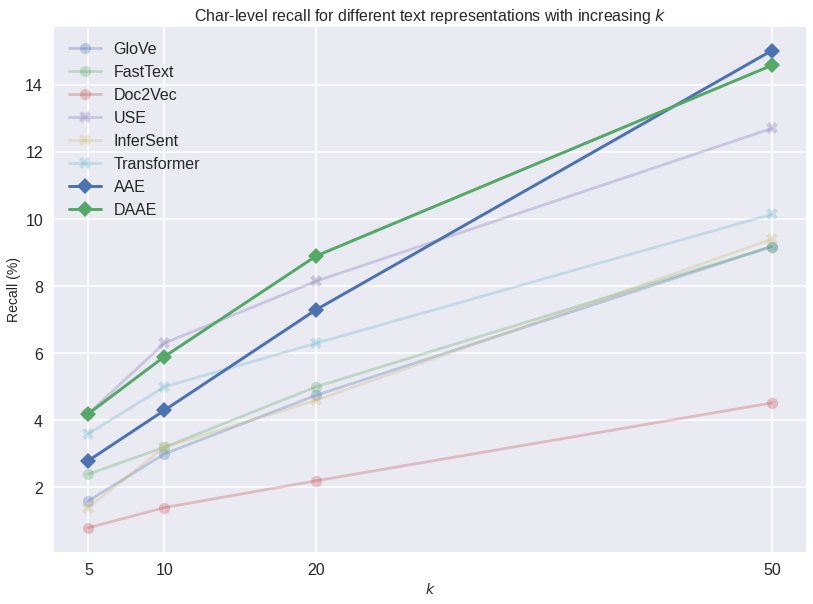

In [40]:
plt.figure(figsize=(12,9))
plt.plot(ks, convert_to_pct(recall_glove), marker='o', label="GloVe", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_fasttext), marker='o', label="FastText", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_doc2vec), marker='o', label="Doc2Vec", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_use), marker='X', label="USE", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_infersent), marker='X', label="InferSent", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_transformer), marker='X', label="Transformer", alpha=0.3)
plt.plot(ks, convert_to_pct(recall_aae), marker='D', label="AAE", linewidth=3)
plt.plot(ks, convert_to_pct(recall_daae), marker='D', label="DAAE", linewidth=3)
plt.legend()
plt.ylabel("Recall (%)", fontsize=14)
plt.xlabel("$\it{k}$", fontsize=14)
plt.xticks(ks, ks)
plt.title("Char-level recall for different text representations with increasing $\it{k}$", fontsize=16)
plt.show()

In [42]:
recall_glove_t = [0.02, 0.027, 0.046, 0.0838]
recall_fasttext_t = [0.034, 0.038, 0.067, 0.0994]
recall_doc2vec_t = [0.014, 0.021, 0.0405, 0.0706]
recall_use_t = [0.062, 0.067, 0.081, 0.1222]
recall_infersent_t = [0.016, 0.026, 0.045, 0.0854]
recall_transformer_t = [0.064, 0.052, 0.074, 0.1156]
recall_aae_t = [0.018, 0.035, 0.072, 0.1048]
recall_daae_t = [0.06, 0.081, 0.109, 0.161]

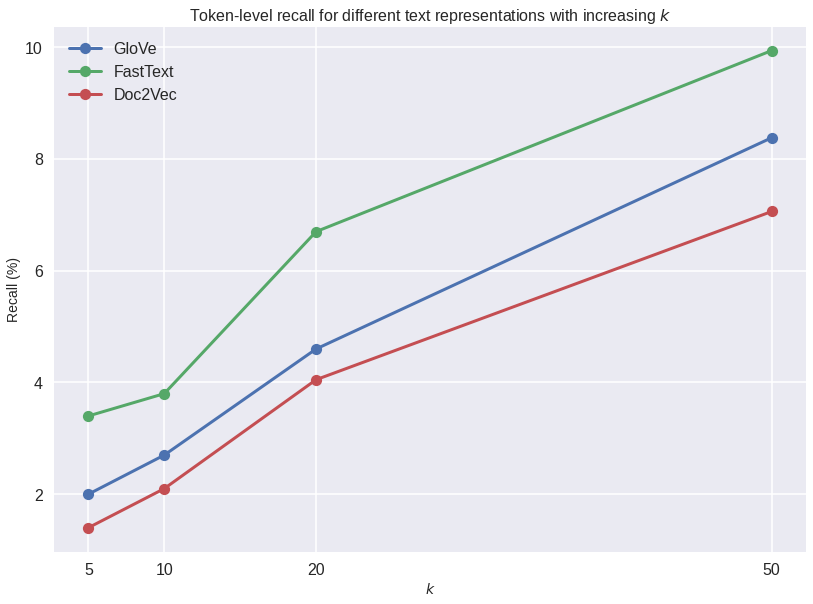

In [45]:
plt.figure(figsize=(12,9))
plt.plot(ks, convert_to_pct(recall_glove_t), marker='o', label="GloVe", linewidth=3)
plt.plot(ks, convert_to_pct(recall_fasttext_t), marker='o', label="FastText", linewidth=3)
plt.plot(ks, convert_to_pct(recall_doc2vec_t), marker='o', label="Doc2Vec", linewidth=3)
#plt.plot(ks, convert_to_pct(recall_use_t), marker='X', label="USE", linewidth=3)
#plt.plot(ks, convert_to_pct(recall_infersent_t), marker='X', label="InferSent", linewidth=3)
#plt.plot(ks, convert_to_pct(recall_transformer_t), marker='X', label="Transformer", linewidth=3)
#plt.plot(ks, convert_to_pct(recall_aae_t), marker='D', label="AAE", linewidth=3)
#plt.plot(ks, convert_to_pct(recall_daae_t), marker='D', label="DAAE", linewidth=3)
plt.legend()
plt.ylabel("Recall (%)", fontsize=14)
plt.xlabel("$\it{k}$", fontsize=14)
plt.xticks(ks, ks)
plt.title("Token-level recall for different text representations with increasing $\it{k}$", fontsize=16)
plt.show()